# Variational Autoencoder for pan-cancer gene expression

**Gregory Way 2017**

This script trains and outputs results for a [variational autoencoder (VAE)](https://arxiv.org/abs/1312.6114)
applied to gene expression data across 33 different cancer-types from The Cancer Genome Atlas (TCGA).

A VAE aproximates the data generating function for the cancer data and learns the lower dimensional manifold a tumor occupies in gene expression space. By compressing the gene expression space into lower dimensional space, the VAE would, ideally, learn biological principles, such as cancer hallmark pathway activations, that help explain how tumors are similar and different. The VAE is also a generative model with a latent space that can be interpolated to observe transitions between cancer states.

The particular model trained in this notebook consists of gene expression input (5000 most variably expressed genes by median absolute deviation) compressed down into two length 100 vectors (mean and variance encoded spaces) which are made deterministic through the reparameterization trick of sampling an epsilon vector from the uniform distribution. The encoded layer is then decoded back to original 5000 dimensions through a single reconstruction layer. I included a layer of batch normalization in the encoding step to prevent dead nodes. The encoding scheme also uses relu activation while the decoder uses a sigmoid activation to enforce positive activations. All weights are glorot uniform initialized. 

Another trick used here to encourage manifold learning is _warm start_ as discussed in [Sonderby et al. 2016](https://arxiv.org/abs/1602.02282). With warm starts, we add a parameter _beta_, which controls the contribution of the KL divergence loss in the total VAE loss (reconstruction + (beta * KL)). In this setting, the model begins training deterministically as a vanilla autoencoder (_beta_ = 0) and slowly ramps up after each epoch linearly until _beta_ = 1. After a parameter sweep, we observed that kappa has little influence in training, therefore, we set  _kappa_ = 1, which is a full VAE.

Much of this script is inspired by the [keras variational_autoencoder.py example](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Layer, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import metrics, optimizers
from keras.callbacks import Callback
import keras

import pydot
import graphviz
from keras.utils import plot_model
from keras_tqdm import TQDMNotebookCallback
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
print(keras.__version__)
tf.__version__

2.1.3


'1.4.0'

In [3]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [4]:
sns.set(style="white", color_codes=True)
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":15,"axes.labelsize":20,
                             'xtick.labelsize':14, 'ytick.labelsize':14})

## Load Functions and Classes

This will facilitate connections between layers and also custom hyperparameters

In [5]:
# Function for reparameterization trick to make model differentiable
def sampling(args):
    
    import tensorflow as tf
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z


class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training
    This function is borrowed from:
    https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py
    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

### Implementing Warm-up as described in Sonderby et al. LVAE

This is modified code from https://github.com/fchollet/keras/issues/2595

In [6]:
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

In [7]:
np.random.seed(123)

## Load Gene Expression Data

In [8]:
rnaseq_file = os.path.join('data', 'pancan_scaled_zeroone_rnaseq.tsv.gz')
rnaseq_df = pd.read_table(rnaseq_file, index_col=0)
print(rnaseq_df.shape)
rnaseq_df.head(2)

(10459, 5000)


,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
TCGA-02-0047-01,0.678296,0.289910,0.034230,0.0,0.0,0.084731,0.031863,0.037709,0.746797,0.687833,...,0.440610,0.428782,0.732819,0.634340,0.580662,0.294313,0.458134,0.478219,0.168263,0.638497
TCGA-02-0055-01,0.200633,0.654917,0.181993,0.0,0.0,0.100606,0.050011,0.092586,0.103725,0.140642,...,0.620658,0.363207,0.592269,0.602755,0.610192,0.374569,0.722420,0.271356,0.160465,0.602560


In [9]:
# Split 10% test set randomly
test_set_percent = 0.1
rnaseq_test_df = rnaseq_df.sample(frac=test_set_percent)
rnaseq_train_df = rnaseq_df.drop(rnaseq_test_df.index)

## Initialize variables and hyperparameters

In [10]:
# Set hyper parameters
original_dim = rnaseq_df.shape[1]
latent_dim = 100

batch_size = 50
epochs = 50
learning_rate = 0.0005

epsilon_std = 1.0
beta = K.variable(0)
kappa = 1

## Encoder

In [11]:
# Input place holder for RNAseq data with specific input size
rnaseq_input = Input(shape=(original_dim, ))

# Input layer is compressed into a mean and log variance vector of size `latent_dim`
# Each layer is initialized with glorot uniform weights and each step (dense connections,
# batch norm, and relu activation) are funneled separately
# Each vector of length `latent_dim` are connected to the rnaseq input tensor
z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# return the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

## Decoder

In [12]:
# The decoding layer is much simpler with a single layer and sigmoid activation
decoder_to_reconstruct = Dense(original_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
rnaseq_reconstruct = decoder_to_reconstruct(z)

## Connect the encoder and decoder to make the VAE

The `CustomVariationalLayer()` includes the VAE loss function (reconstruction + (beta * KL)), which is what will drive our model to learn an interpretable representation of gene expression space.

The VAE is compiled with an Adam optimizer and built-in custom loss function. The `loss_weights` parameter ensures beta is updated at each epoch end callback

In [13]:
adam = optimizers.Adam(lr=learning_rate)
vae_layer = CustomVariationalLayer()([rnaseq_input, rnaseq_reconstruct])
vae = Model(rnaseq_input, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])

vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5000)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          500100      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          500100      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 100)          400         dense_1[0][0]                    
__________________________________________________________________________________________________
batch_norm

/home/gway/anaconda3/envs/tybalt/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.


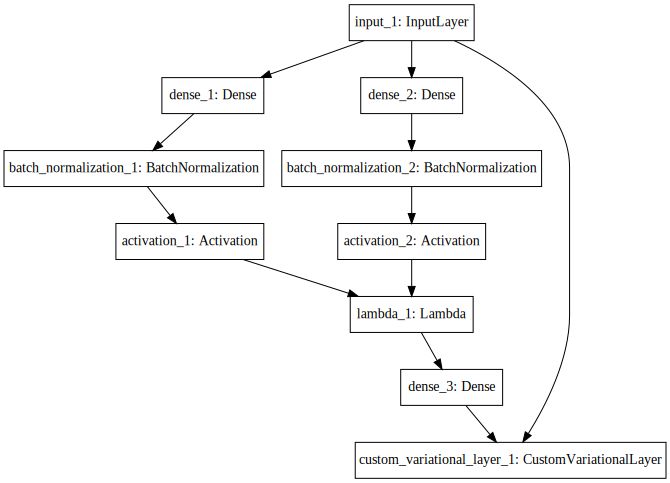

In [14]:
# Visualize the connections of the custom VAE model
output_model_file = os.path.join('figures', 'onehidden_vae_architecture.png')
plot_model(vae, to_file=output_model_file)

SVG(model_to_dot(vae).create(prog='dot', format='svg'))

## Train the model

The training data is shuffled after every epoch and 10% of the data is heldout for calculating validation loss.

In [15]:
%%time
hist = vae.fit(np.array(rnaseq_train_df),
               shuffle=True,
               epochs=epochs,
               verbose=0,
               batch_size=batch_size,
               validation_data=(np.array(rnaseq_test_df), None),
               callbacks=[WarmUpCallback(beta, kappa),
                          TQDMNotebookCallback(leave_inner=True, leave_outer=True)])


CPU times: user 12min 51s, sys: 1min 34s, total: 14min 25s
Wall time: 5min 16s


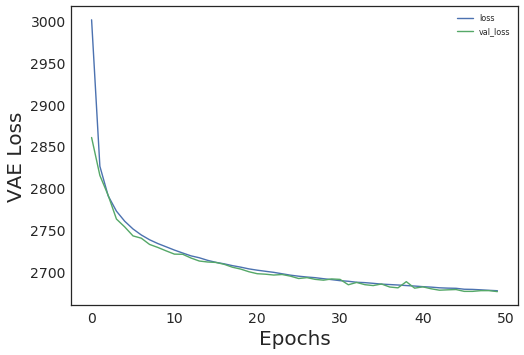

In [16]:
# Visualize training performance
history_df = pd.DataFrame(hist.history)
hist_plot_file = os.path.join('figures', 'onehidden_vae_training.pdf')
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

## Compile and output trained models

We are interested in:

1. The model to encode/compress the input gene expression data
  * Can be possibly used to compress other tumors
2. The model to decode/decompress the latent space back into gene expression space
  * This is our generative model
3. The latent space compression of all pan cancer TCGA samples
  * Non-linear reduced dimension representation of tumors can be used as features for various tasks
    * Supervised learning tasks predicting specific gene inactivation events
    * Interpolating across this space to observe how gene expression changes between two cancer states
4. The weights used to compress each latent node
  * Potentially indicate learned biology differentially activating tumors

### Encoder model

In [17]:
# Model to compress input
encoder = Model(rnaseq_input, z_mean_encoded)

In [18]:
# Encode rnaseq into the hidden/latent representation - and save output
encoded_rnaseq_df = encoder.predict_on_batch(rnaseq_df)
encoded_rnaseq_df = pd.DataFrame(encoded_rnaseq_df, index=rnaseq_df.index)

encoded_rnaseq_df.columns.name = 'sample_id'
encoded_rnaseq_df.columns = encoded_rnaseq_df.columns + 1
encoded_file = os.path.join('data', 'encoded_rnaseq_onehidden_warmup_batchnorm.tsv')
encoded_rnaseq_df.to_csv(encoded_file, sep='\t')

### Decoder (generative) model

In [19]:
# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim, ))  # can generate from any sampled z vector
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

## Save the encoder/decoder models for future investigation

In [20]:
encoder_model_file = os.path.join('models', 'encoder_onehidden_vae.hdf5')
decoder_model_file = os.path.join('models', 'decoder_onehidden_vae.hdf5')

encoder.save(encoder_model_file)
decoder.save(decoder_model_file)

##  Model Interpretation - Sanity Check


###  Observe the distribution of node activations.

We want to ensure that the model is learning a distribution of feature activations, and not zeroing out features.

In [21]:
# What are the most and least activated nodes
sum_node_activity = encoded_rnaseq_df.sum(axis=0).sort_values(ascending=False)

# Top 10 most active nodes
print(sum_node_activity.head(10))

# Bottom 10 least active nodes
sum_node_activity.tail(10)

sample_id
82    29584.533203
5     29578.066406
28    24349.054688
16    24086.214844
6     24084.980469
63    23750.429688
8     23380.603516
57    23047.580078
87    23010.695312
37    22798.029297
dtype: float32


sample_id
91    14282.995117
45    14082.565430
34    13749.231445
18    13509.525391
97    13373.916992
32    13035.963867
92    12693.304688
2     12593.957031
20    11392.033203
4     10859.074219
dtype: float32

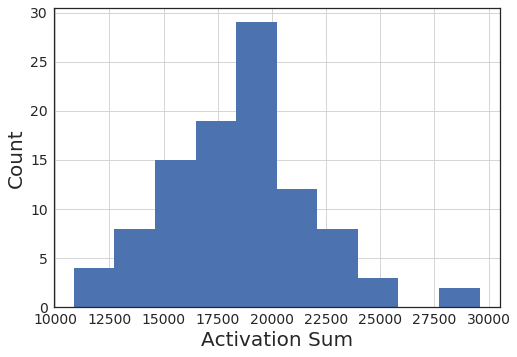

In [22]:
# Histogram of node activity for all 100 latent features
sum_node_activity.hist()
plt.xlabel('Activation Sum')
plt.ylabel('Count');

What does an example distribution of two latent features look like?

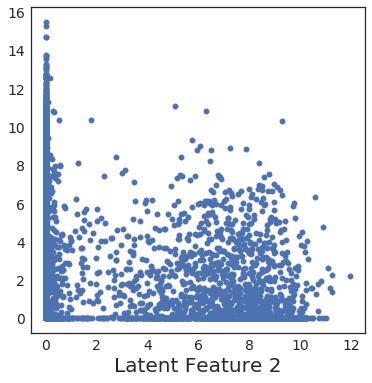

In [23]:
# Example of node activation distribution for the first two latent features
plt.figure(figsize=(6, 6))
plt.scatter(encoded_rnaseq_df.iloc[:, 1], encoded_rnaseq_df.iloc[:, 2])
plt.xlabel('Latent Feature 1')
plt.xlabel('Latent Feature 2');

###  Observe reconstruction fidelity

In [24]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct = decoder.predict(np.array(encoded_rnaseq_df))
input_rnaseq_reconstruct = pd.DataFrame(input_rnaseq_reconstruct, index=rnaseq_df.index,
                                        columns=rnaseq_df.columns)
input_rnaseq_reconstruct.head(2)

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
TCGA-02-0047-01,0.691638,0.196529,0.194204,0.035744,0.027784,0.055622,0.064214,0.043093,0.721925,0.690764,...,0.451367,0.486186,0.788487,0.680068,0.575140,0.324611,0.385545,0.605859,0.210192,0.644549
TCGA-02-0055-01,0.099189,0.592460,0.188617,0.106664,0.044037,0.100698,0.115720,0.069524,0.075663,0.055188,...,0.564506,0.519069,0.646698,0.590475,0.624337,0.385787,0.570150,0.246259,0.181708,0.649352


In [25]:
reconstruction_fidelity = rnaseq_df - input_rnaseq_reconstruct

gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(rnaseq_df.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene mean', 'gene abs(sum)']).T
gene_summary.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
PPAN-P2RY11,-0.020364,0.230511
GSTT1,0.024710,0.229753
GSTM1,0.005650,0.216558
TBC1D3G,-0.010398,0.194532
RPS28,0.012242,0.176380


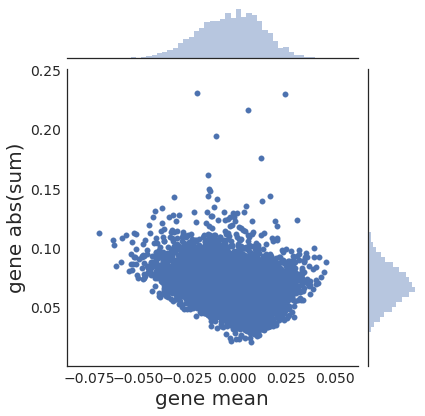

In [26]:
# Mean of gene reconstruction vs. absolute reconstructed difference per sample
g = sns.jointplot('gene mean', 'gene abs(sum)', data=gene_summary, stat_func=None);